<a href="https://colab.research.google.com/github/multimodalart/latent-diffusion-notebook/blob/main/Latent_Diffusion_LAION_400M_model_text_to_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Latent Diffusion model Text-to-image synthesis with 1.45B parameter model 
### [Latent Diffusion](https://github.com/CompVis/latent-diffusion) and the [LAION-400M dataset](https://laion.ai/laion-400-open-dataset/) released model by CompVis

##### Colab assembled by [@multimodalart](https://twitter.com/multimodalart)

## Save model and outputs on Google Drive? 

In [ ]:
#@markdown Enable saving outputs to Google Drive to save your creations at AI/models
save_outputs_to_google_drive = True #@param {type:"boolean"}
#@markdown Enable saving models to Google Drive to avoid downloading the 6GB model every Colab instance
save_models_to_google_drive = True #@param {type:"boolean"}

if save_outputs_to_google_drive or save_models_to_google_drive:
    from google.colab import drive
    try:
      drive.mount('/content/gdrive')
    except:
      save_outputs_to_google_drive = False
      save_models_to_google_drive = False

model_path = "/content/gdrive/MyDrive/AI/models" if save_models_to_google_drive else "/models/ldm/text2img-large"
outputs_path = "/content/gdrive/MyDrive/AI/Latent_Diffusion" if save_outputs_to_google_drive else "/content/outputs"
!mkdir -p $model_path
!mkdir -p $outputs_path
print(f"Model will be stored at {model_path}")
print(f"Outputs will be saved to {outputs_path}")


# Setup stuff

In [ ]:
#@title Installation
!git clone https://github.com/crowsonkb/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
!pip install transformers
import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan 

Now, download the checkpoint (~5.7 GB). This will usually take 3-6 minutes.

In [ ]:
#@title Download model
%cd /content/latent-diffusion

import os
if os.path.isfile(f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt"):
    print("Using saved model from Google Drive")
else:    
    !wget -O $model_path/latent_diffusion_txt2img_f8_large.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt

Let's also check what type of GPU we've got.

In [ ]:
!nvidia-smi

Load it.

In [ ]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.half().cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("configs/latent-diffusion/cin256-v2.yaml")  
    model = load_model_from_config(config, "models/ldm/cin256-v2/model.ckpt")
    return model

In [ ]:
#@title Import stuff
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm.auto import tqdm, trange
tqdm_auto_model = __import__("tqdm.auto", fromlist=[None]) 
sys.modules['tqdm'] = tqdm_auto_model
from einops import rearrange
from torchvision.utils import make_grid
import transformers
import gc
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

In [ ]:
#@title Load necessary functions
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda:0")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

def run(opt):
    torch.cuda.empty_cache()
    gc.collect()
    config = OmegaConf.load("configs/latent-diffusion/txt2img-1p4B-eval.yaml")  # TODO: Optionally download from same location as ckpt and chnage this logic
    model = load_model_from_config(config, f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt")  # TODO: check path

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)
    if opt.plms:
        opt.ddim_eta = 0
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)
    
    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    prompt = opt.prompt


    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))

    all_samples=list()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            with model.ema_scope():
                uc = None
                if opt.scale > 0:
                    uc = model.get_learned_conditioning(opt.n_samples * [""])
                for n in trange(opt.n_iter, desc="Sampling"):
                    c = model.get_learned_conditioning(opt.n_samples * [prompt])
                    shape = [4, opt.H//8, opt.W//8]
                    samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                    conditioning=c,
                                                    batch_size=opt.n_samples,
                                                    shape=shape,
                                                    verbose=False,
                                                    unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,
                                                    eta=opt.ddim_eta)

                    x_samples_ddim = model.decode_first_stage(samples_ddim)
                    x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)

                    for x_sample in x_samples_ddim:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        Image.fromarray(x_sample.astype(np.uint8)).save(os.path.join(sample_path, f"{base_count:04}.png"))
                        base_count += 1
                    all_samples.append(x_samples_ddim)


    # additionally, save as grid
    grid = torch.stack(all_samples, 0)
    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=opt.n_samples)

    # to image
    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
    
    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'{prompt.replace(" ", "-")}.png'))
    display(Image.fromarray(grid.astype(np.uint8)))
    #print(f"Your samples are ready and waiting four you here: \n{outpath} \nEnjoy.")

# Do the run

Loading model from /content/gdrive/MyDrive/AI/models/latent_diffusion_txt2img_f8_large.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 872.30 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Data shape for PLMS sampling is (4, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

Data shape for PLMS sampling is (4, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

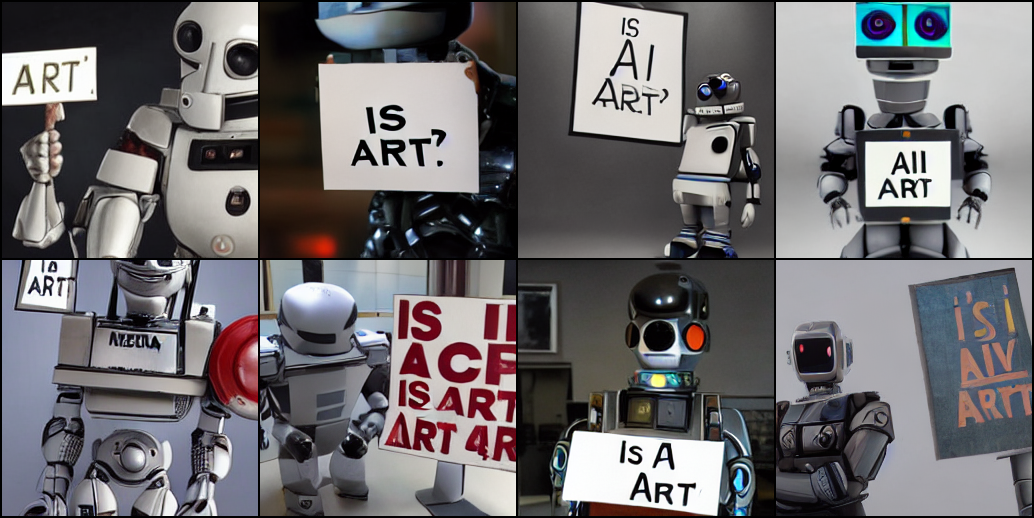

In [ ]:
#@title Parameters
import argparse
Prompt = "A mecha robot holding a sign that reads: 'Is AI art, art?'" #@param{type:"string"}
Steps = 50 #@param {type:"integer"}
ETA = 0 #@param{type:"integer"}
Iterations = 2 #@param{type:"integer"}
Width=256 #@param{type:"integer"}
Height=256 #@param{type:"integer"}
Samples_in_parallel=4 #@param{type:"integer"}
Diversity_scale=5.0 #@param {type:"number"}
PLMS_sampling=True #@param {type:"boolean"}

args = argparse.Namespace(
    prompt = Prompt, 
    outdir=f'{outputs_path}',
    ddim_steps = Steps,
    ddim_eta = ETA,
    n_iter = Iterations,
    W=Width,
    H=Height,
    n_samples=Samples_in_parallel,
    scale=Diversity_scale,
    plms=PLMS_sampling
)
run(args)